In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

# Step 1.1: Load the Data
# The usual file name is 'u.data', but it might be different if you have a different version.
# Make sure the separator is correct (tab-separated in the original MovieLens 100k dataset).

ratings_columns = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('u.data', sep='\t', names=ratings_columns, engine='python')

# Display the first few rows to understand the structure
print(ratings.head())

# Step 1.2: Data Exploration
# Basic stats
print(ratings.describe())

# Check for null values
print(ratings.isnull().sum())

# Step 1.3: Data Cleaning
# As this dataset is relatively clean, there might not be much to do here.
# But it's good practice to ensure IDs are treated as categorical data.
ratings['user_id'] = ratings['user_id'].astype('category')
ratings['item_id'] = ratings['item_id'].astype('category')

# Step 1.4: Data Transformation
# No transformations are needed for the Surprise library, but let's prepare the implicit feedback matrix.
# Here, the assumption is that all ratings are implicit positive feedback.
# You might want to threshold the ratings to consider only high ratings as positive feedback.

# Create a sparse matrix for implicit feedback
user_ids = ratings['user_id'].cat.codes
item_ids = ratings['item_id'].cat.codes
ratings_implicit = coo_matrix((np.ones_like(user_ids), (user_ids, item_ids)))

# Step 1.5: Train/Test Split
# For Surprise, we'll use built-in train-test split methods later in the pipeline.
# For implicit feedback, we'll use the train_test_split function from the implicit library when we reach that step.

# (The actual splitting will happen in their respective sections of the pipeline.)


   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
            user_id        item_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08
user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64


In [ ]:
# Grid Search for Dataset ML100K (implicit feedback)
# Results:
# Best MAP: 1.0
# Best Params: {'factors': 10, 'regularization': 0.01, 'iterations': 10}

import numpy as np
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import train_test_split, mean_average_precision_at_k
from implicit.nearest_neighbours import bm25_weight

# Hyperparameters to search over
factors = [10, 50, 100]
regularizations = [0.01, 0.1, 1.0]
iterations = [10, 50, 100]

# Step 2.1: Weight the matrix - BM25 is a common weighting scheme in Information Retrieval
ratings_implicit_weighted = bm25_weight(ratings_implicit, K1=100, B=0.8)

# Step 2.2: Train/Test Split
# Using an 80-20 split for train and test sets
train_implicit, test_implicit = train_test_split(ratings_implicit_weighted, train_percentage=0.8)

# Transpose the train matrix as required by the library
train_implicit = train_implicit.T

best_map = 0
best_params = {}

# Step 2.3: Grid search
for factor in factors:
    for regularization in regularizations:
        for iteration in iterations:
            # Configure the ALS model
            model_implicit = AlternatingLeastSquares(factors=factor,
                                                     regularization=regularization,
                                                     iterations=iteration,
                                                     calculate_training_loss=True,
                                                     use_gpu=False)

            # Train the ALS model
            model_implicit.fit(train_implicit)

            # Evaluate the model using mean average precision at k
            map_score = mean_average_precision_at_k(model_implicit, train_implicit, test_implicit.T, K=10)

            # Update best parameters if current score is better
            if map_score > best_map:
                best_map = map_score
                best_params = {'factors': factor, 'regularization': regularization, 'iterations': iteration}

# Output the best parameters
print(f"Best MAP: {best_map}")
print(f"Best Params: {best_params}")

# Step 2.4: Retrain the model with the best parameters found
best_model_implicit = AlternatingLeastSquares(factors=best_params['factors'],
                                               regularization=best_params['regularization'],
                                               iterations=best_params['iterations'],
                                               calculate_training_loss=True,
                                               use_gpu=False)

best_model_implicit.fit(train_implicit)
# Now final_model_implicit is the trained model with the best parameters from the grid search


In [ ]:
# Grid Search for Dataset ML100K (explicit)
# Results:
# 0.9430248264478984
# {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}

from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split as surprise_train_test_split

# Step 2.1: Setup the reader and dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], reader)

# Step 2.2: Define the parameter grid for grid search
param_grid = {
    'n_factors': [10, 50, 100],
    'n_epochs': [5, 10, 20],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}

# Step 2.3: Setup GridSearchCV
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# Step 2.4: Run the grid search on the entire dataset
gs.fit(data)

# Step 2.5: Best parameters and best score
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

# Step 2.6: Train/Test Split
# Using an 80-20 split for train and test sets
train_explicit, test_explicit = surprise_train_test_split(data, test_size=0.2)

# Step 2.7: Retrieve the best model from the grid search
best_model_explicit = gs.best_estimator['rmse']

# Step 2.8: Train the best SVD model
best_model_explicit.fit(train_explicit)


In [2]:
# Retrain the model with the best parameters found
# As per your results, the best parameters are:
# 'factors': 10, 'regularization': 0.01, 'iterations': 10

import numpy as np
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import train_test_split, mean_average_precision_at_k
from implicit.nearest_neighbours import bm25_weight

# Weight the matrix - BM25 is a common weighting scheme in Information Retrieval
ratings_implicit_weighted = bm25_weight(ratings_implicit, K1=100, B=0.8)

# Using an 80-20 split for train and test sets
train_implicit, test_implicit = train_test_split(ratings_implicit_weighted, train_percentage=0.8)

# Transpose the train matrix as required by the library
train_implicit = train_implicit.T

# Initialize the ALS model with the best parameters
final_model_implicit = AlternatingLeastSquares(factors=10,
                                               regularization=0.01,
                                               iterations=10,
                                               calculate_training_loss=True,
                                               use_gpu=False)  # Set to True if you have a CUDA compatible GPU

# Train the model on the full training set
final_model_implicit.fit(train_implicit)

# At this point, final_model_implicit is the trained model with the best parameters from the grid search

# If you want to save this model for later use, you can use the following:
import pickle

with open('final_model_implicit.pkl', 'wb') as f:
    pickle.dump(final_model_implicit, f)

# To load it back:
with open('final_model_implicit.pkl', 'rb') as f:
    final_model_implicit = pickle.load(f)

# Use the model to make predictions or further analysis as required


/home/stef/.local/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0008609294891357422 seconds
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
# Retrain the model with the best parameters found
# As per your results, the best parameters are:
# 'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split as surprise_train_test_split

# Given best parameters from grid search
best_params = {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}

# Initialize the SVD model with the best parameters
final_model_explicit = SVD(n_factors=best_params['n_factors'],
                           n_epochs=best_params['n_epochs'],
                           lr_all=best_params['lr_all'],
                           reg_all=best_params['reg_all'])

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], reader)

# Train/Test Split
train_explicit, test_explicit = surprise_train_test_split(data, test_size=0.2)

# Train the final model on the full training set
final_model_explicit.fit(train_explicit)

# The final_model_explicit is now trained with the best parameters
# You can now use this model to make predictions or evaluate it further

# If you want to save this model for later use, you can use the following:
import pickle

# Save the trained model to a file
with open('final_model_explicit.pkl', 'wb') as file:
    pickle.dump(final_model_explicit, file)

# To load it back in the future:
with open('final_model_explicit.pkl', 'rb') as file:
    final_model_explicit = pickle.load(file)

# Now you can use final_model_explicit to make predictions, etc.


  0%|          | 0/1411 [00:00<?, ?it/s]

  0%|          | 0/1411 [00:00<?, ?it/s]

  0%|          | 0/1411 [00:00<?, ?it/s]

For K=5: AUC=0.5925, NDCG=0.3007, Precision@K=0.3307


  0%|          | 0/1411 [00:00<?, ?it/s]

  0%|          | 0/1411 [00:00<?, ?it/s]

  0%|          | 0/1411 [00:00<?, ?it/s]

For K=10: AUC=0.5925, NDCG=0.2903, Precision@K=0.3393


  0%|          | 0/1411 [00:00<?, ?it/s]

  0%|          | 0/1411 [00:00<?, ?it/s]

  0%|          | 0/1411 [00:00<?, ?it/s]

For K=15: AUC=0.5925, NDCG=0.2910, Precision@K=0.3523


  0%|          | 0/1411 [00:00<?, ?it/s]

  0%|          | 0/1411 [00:00<?, ?it/s]

  0%|          | 0/1411 [00:00<?, ?it/s]

For K=20: AUC=0.5925, NDCG=0.2958, Precision@K=0.3681


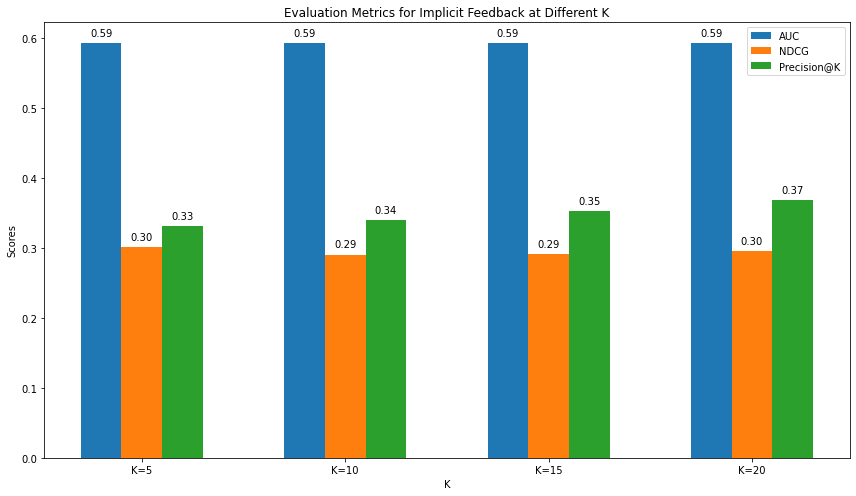

In [4]:
# Evaluate Trained ALS-Model (implicit) with AUC, NDGC and Precision@K
# Use 4 different K (5, 10, 15, 20)
# Plot results as barchart

import matplotlib.pyplot as plt
from implicit.evaluation import AUC_at_k, ndcg_at_k, precision_at_k

# Assuming you have a range of K values you want to test
K_values = [5, 10, 15, 20]

# Initialize lists to store the metrics for each K
auc_scores = []
ndcg_scores = []
precision_at_k_scores = []

# Compute the metrics for each K
for K in K_values:
    auc = AUC_at_k(final_model_implicit, train_implicit, test_implicit.T)
    ndcg = ndcg_at_k(final_model_implicit, train_implicit, test_implicit.T, K=K)
    precision = precision_at_k(final_model_implicit, train_implicit, test_implicit.T, K=K)

    auc_scores.append(auc)
    ndcg_scores.append(ndcg)
    precision_at_k_scores.append(precision)

    print(f'For K={K}: AUC={auc:.4f}, NDCG={ndcg:.4f}, Precision@K={precision:.4f}')

# Now we plot the metrics in a bar chart
x = range(len(K_values))

plt.figure(figsize=(12, 7))

plt.bar([i - 0.2 for i in x], auc_scores, width=0.2, label='AUC')
plt.bar(x, ndcg_scores, width=0.2, label='NDCG', align='center')
plt.bar([i + 0.2 for i in x], precision_at_k_scores, width=0.2, label='Precision@K')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('K')
plt.ylabel('Scores')
plt.title('Evaluation Metrics for Implicit Feedback at Different K')
plt.xticks(x, [f'K={k}' for k in K_values])
plt.legend()

# Adding the actual value on top of each bar for clarity
for i in range(len(K_values)):
    plt.text(i - 0.2, auc_scores[i] + 0.01, f'{auc_scores[i]:.2f}', ha='center')
    plt.text(i, ndcg_scores[i] + 0.01, f'{ndcg_scores[i]:.2f}', ha='center')
    plt.text(i + 0.2, precision_at_k_scores[i] + 0.01, f'{precision_at_k_scores[i]:.2f}', ha='center')

plt.tight_layout()
plt.show()


In [5]:


from collections import defaultdict
from sklearn.metrics import roc_auc_score
from surprise import accuracy

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.'''
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def custom_auc_at_k(predictions, all_items, threshold=3.5):
    '''Calculate AUC for all items, not just top k.'''
    y_true = []
    y_scores = []

    # We consider all the items as the possible item space.
    user_est_true = defaultdict(list)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated score and slice off the k highest
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Ratings are marked as '1' if they are above the threshold.
        y_true.extend([1 if true_r >= threshold else 0 for (_, true_r) in user_ratings])
        y_scores.extend([est for (est, _) in user_ratings])

    # We need at least one positive and one negative sample for AUC
    if np.sum(y_true) > 0 and np.sum(y_true) < len(y_true):
        return roc_auc_score(y_true, y_scores)
    else:
        return float('nan')  # or an appropriate value that indicates an undefined AUC


def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (DCG)"""
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

def ndcg_at_k(r, k=10, method=0):
    """Score is normalized discounted cumulative gain (NDCG)"""
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

def custom_ndcg_at_k(predictions, k=10, threshold=3.5):
    """Average NDCG for all users"""
    ndcg_scores = []
    top_n = get_top_n(predictions, n=k)
    for uid, user_ratings in top_n.items():
        y_true = [1 if r >= threshold else 0 for (_, r) in user_ratings]
        ndcg = ndcg_at_k(y_true, k)
        ndcg_scores.append(ndcg)
    return np.mean(ndcg_scores)

def custom_precision_at_k(predictions, k=10, threshold=3.5):
    """Calculate precision at k for each user and average them."""
    precisions = []
    top_n = get_top_n(predictions, n=k)
    for uid, user_ratings in top_n.items():
        n_rel = sum((1 for (_, r) in user_ratings if r >= threshold))
        precision = n_rel / len(user_ratings)
        precisions.append(precision)
    return np.mean(precisions)


For K=5: AUC=0.7731, NDCG=0.9394, Precision@K=0.8168
For K=10: AUC=0.7731, NDCG=0.9394, Precision@K=0.7372
For K=15: AUC=0.7731, NDCG=0.9394, Precision@K=0.6962
For K=20: AUC=0.7731, NDCG=0.9394, Precision@K=0.6688


<Figure size 864x504 with 0 Axes>

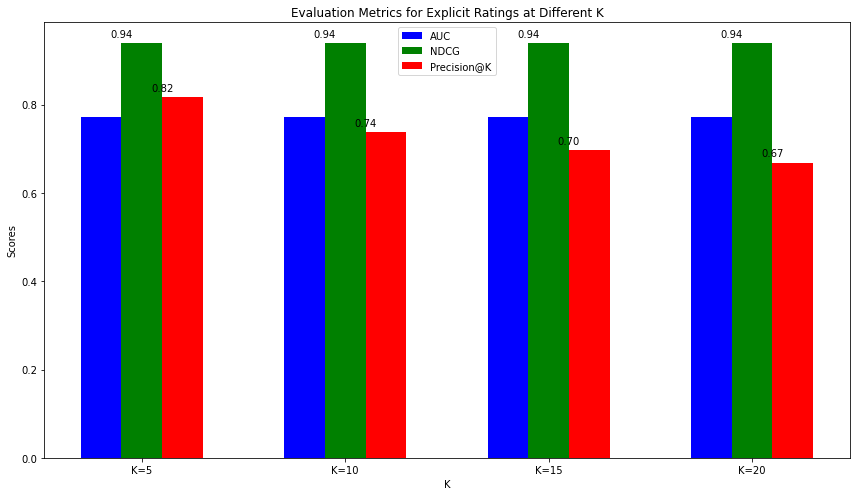

In [6]:
# Evaluate Trained SVD-Model (explicit) with AUC, NDGC and Precision@K
# Use 4 different K (5, 10, 15, 20)
# Plot results as barchart

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# First, define the custom evaluation functions here (custom_ndcg_at_k, custom_precision_at_k)

def custom_auc_at_k(predictions):
    '''Calculate AUC for all items for each user and average them.'''
    y_trues = []
    y_scores = []

    # Convert predictions to dict
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    # Calculate AUC for each user
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        # Separate true ratings and estimated scores
        y_true = [1 if true_r >= 3.5 else 0 for (_, true_r) in user_ratings]
        y_score = [est for (est, _) in user_ratings]
        # We need at least one positive and one negative sample for AUC
        if sum(y_true) > 0 and sum(y_true) < len(y_true):
            y_trues.extend(y_true)
            y_scores.extend(y_score)

    return roc_auc_score(y_trues, y_scores)

# Assuming you have a range of K values you want to test
K_values = [5, 10, 15, 20]

# Make predictions on the test set
predictions = final_model_explicit.test(test_explicit)

# Initialize lists to store the metrics for each K
auc_scores = []
ndcg_scores = []
precision_at_k_scores = []

# Compute the metrics for each K
for K in K_values:
    # AUC is calculated for all items, hence not dependent on K
    auc = custom_auc_at_k(predictions)
    ndcg = custom_ndcg_at_k(predictions, k=K)
    precision = custom_precision_at_k(predictions, k=K)

    auc_scores.append(auc)  # This will be the same for all K values
    ndcg_scores.append(ndcg)
    precision_at_k_scores.append(precision)

    print(f'For K={K}: AUC={auc:.4f}, NDCG={ndcg:.4f}, Precision@K={precision:.4f}')

# Since AUC is the same for all K, just repeat the first value
auc_scores = [auc_scores[0]] * len(K_values)

# Now we plot the metrics in a bar chart
x = np.arange(len(K_values))

plt.figure(figsize=(12, 7))

# AUC doesn't change with K, so we plot it as a line instead of bars
plt.figure(figsize=(12, 7))

plt.bar(x - 0.2, auc_scores, width=0.2, color='blue', align='center', label='AUC')
plt.bar(x, ndcg_scores, width=0.2, color='green', align='center', label='NDCG')
plt.bar(x + 0.2, precision_at_k_scores, width=0.2, color='red', align='center', label='Precision@K')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('K')
plt.ylabel('Scores')
plt.title('Evaluation Metrics for Explicit Ratings at Different K')
plt.xticks(x, [f'K={k}' for k in K_values])
plt.legend()

# Adding the actual value on top of each bar for clarity
for i, (ndcg, precision) in enumerate(zip(ndcg_scores, precision_at_k_scores)):
    plt.text(i - 0.1, ndcg + 0.01, f'{ndcg:.2f}', ha='center', va='bottom')
    plt.text(i + 0.1, precision + 0.01, f'{precision:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
